# Make Topic Modelling Great Again

Recent advances in artificial neural networks have been shown to be very fruitful in several branches of NLP. Beside self-supervised word embedding models like Word2Vec, more complicated architectures such as LSTM's emerged to face the problem of text classification, in particular. However, these models suffer from the fact that huge amounts of data are required for training, and for these classification models data needs to be labeled, which often is infeasible in practice.
On the other hand, topic modelling is a stochastic tool to discover hidden semantic structures in a text corpus in an unsupervised manner. As it does not make use of neural nets, it is also well suited to problems where only few data is available. The goal of this project is to build a classifying system that is able to assign probabilities of latent topics to any given text. 

## Python Packages

Before we begin, let us initialize the libraries we make use of. We use tweepy for data mining, pandas for data wrangling, numpy for calculations and matplotlib.pyplot for visualizations, as well as seaborn. Our core model employs gensim. All the other packages are used for data cleaning and preprocessing.

In [ ]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from textblob import TextBlob, Word
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from string import punctuation

## Data Mining

We used the Twitter API to scrape latest Donald Trump tweets which we then analyzed. The downside of Tweepy is that access to tweets is very limited for (security) reasons. In order to get the largest possible amount of tweets at time, one might want to use the following code.

In [ ]:
#initialize tweepy
consumer_key = 'your_consumer_key'
consumer_secret = 'your_consumer_secret'

access_token = 'your_access_token'
access_token_secret = 'your_access_token_secret'

auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth)


#scrape the latest 200 trump tweets manually and append them to the empty list
all_tweets = []
coll_tweets = api.user_timeline('realDonaldTrump',count=200,tweet_mode='extended')
all_tweets.extend(coll_tweets)


#scrape previously released tweets and append them to the list of tweets that were already scraped
#as long as access is permitted
while(len(coll_tweets)>0):
    oldest = all_tweets[-1].id -1
    coll_tweets = api.user_timeline('realDonaldTrump',count=200,max_id=oldest,tweet_mode='extended')
    all_tweets.extend(coll_tweets)

Once the access to tweets is denied, one should wait for a few minutes and repeat the procedure in order to gain more data. Next, we used the following function to transform the collected tweets into a data frame. In addition to the tweet text on which we focus our attention for further analysis, we also extracted the precise release date which enables us to easily mine additional data.

In [ ]:
#function to transform collected tweets into pandas dataframe
def tweets_to_df(all_tweets):
    data = pd.DataFrame({"Text": [tweet.full_text for tweet in all_tweets],"Year": [tweet.created_at.year for tweet in all_tweets], "Month": [tweet.created_at.month for tweet in all_tweets], "Day": [tweet.created_at.day for tweet in all_tweets],"Hour": [tweet.created_at.hour for tweet in all_tweets]})
    return data

## Data Cleansing

Our function for data cleansing includes lowercasing, removing stopwords, removing punctuation and lemmatization. Moreover, we removed uninformative words that were discovered empirically.

In [ ]:
#function to remove undesirable punctuation from a word
set(punctuation)

def replace_char(w):
    for c in set(punctuation):
        w = w.replace(c,'')
    return w

#list of uninformative words found in words of all collected tweets
uninformatives = ['rt','amp','realdonaldtrump','u','new','would','get','want','never','one','back','even','done','like','make','must','know','ever','thing','going','see','first','two','way','said','also','made','you','look','show','say','left','got','number','getting','really','could','and','come','keep','long','think','year','it','much','many','medium','far','the','day','today','time','president']

#function which cleans a single document
def clean_tweets_str(tweet):
    stop = stopwords.words('english')
    #lowercase all words
    ess_words = [w.lower() for w in tweet.split()]
    #remove stopwords
    ess_words = [w for w in ess_words if not w in stop]
    #remove redundant characters
    ess_words = [replace_char(w) for w in ess_words][:-1]
    #word lemmatization
    ess_words = [Word(w).lemmatize() for w in ess_words]
    #remove uninformative words
    ess_words = [w for w in ess_words if not w in uninformatives]
    string = ''
    for w in ess_words:
        string = string  + w + ' '
    return string

## Data Preprocessing

For further processing, we first transform the previously built data frame of tweets into a list which contains all cleaned tweets. Afterwards, we define the dictionary of words that is later used by our model. Moreover, tweets are translated into a bag of word corpus, which is also fed into the model.

In [ ]:
#function that extracts cleaned tweets in a list   
def extract_tweets(df):
    all_tweets = []
    for tweet in df.Text:
        all_tweets += [clean_tweets_str(tweet)]
    return all_tweets

data = tweets_to_df(all_tweets)
tweets = extract_tweets(data)

In [ ]:
#function to get the gensim dictionary
def get_dict(df):
    corpus = [tweet.split() for tweet in extract_tweets(df)]
    id2word = gensim.corpora.Dictionary(corpus)
    return id2word

dictionary = get_dict(data)

#function to get the gensim bow corpus
def get_corpus(df):
    corpus = [dictionary.doc2bow(tweet.split()) for tweet in extract_tweets(df)]
    return corpus

corpus = get_corpus(data)

## Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative statistical model which we will be using for topic modelling in this project. The underlying assumption in LDA is that the observed text documents are sampled from a mixture of topic distributions, where each topic distribution is represented by probabilities of generating various words. 
Once the number of topics is specified, the whole procedure works unsupervised. Although scikit-learn provides LDA, we use gensim for our implementation since it comes equipped with many useful features for LDA models. The following shows our baseline model. The crucial parameters to be tuned are the number of topics and the decay. Here, decay is a measure of how rapidly previously learned structures are forgotten and as such it plays a central role in online learning, which will be used later. Decay corresponds to 'Kappa' in Matthew D. Hoffman, David M. Blei, Francis Bach: “Online Learning for Latent Dirichlet Allocation NIPS‘10” and takes values between 0.5 and 1. The initial values for the number of topics and for decay were arbitrarily set to 7 and 1, respectively.

In [72]:
num_topics = 7

lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus = corpus,
                           num_topics = num_topics,
                           id2word = dictionary,
                           chunksize = 100,
                           workers = 7,
                           passes = 50,
                           eval_every = 1,
                           per_word_topics = True,
                           decay = 1
                            )

lda_train.print_topics(7,num_words=15)

[(0,
  '0.009*"great" + 0.009*"thank" + 0.008*"people" + 0.008*"dbongino" + 0.006*"good" + 0.005*"america" + 0.005*"rating" + 0.005*"approval" + 0.005*"important" + 0.004*"country" + 0.004*"prime" + 0.004*"world" + 0.004*"american" + 0.004*"minister" + 0.004*"read"'),
 (1,
  '0.021*"great" + 0.009*"state" + 0.008*"america" + 0.008*"people" + 0.007*"big" + 0.007*"thank" + 0.007*"country" + 0.005*"united" + 0.005*"support" + 0.005*"russia" + 0.005*"tonight" + 0.004*"job" + 0.004*"pm" + 0.004*"hard" + 0.004*"money"'),
 (2,
  '0.018*"great" + 0.007*"congratulation" + 0.007*"fbi" + 0.006*"last" + 0.005*"people" + 0.005*"state" + 0.004*"week" + 0.004*"thank" + 0.004*"judicialwatch" + 0.004*"russia" + 0.003*"country" + 0.003*"news" + 0.003*"incredible" + 0.003*"poll" + 0.003*"democrat"'),
 (3,
  '0.020*"china" + 0.011*"deal" + 0.011*"tariff" + 0.009*"great" + 0.009*"country" + 0.009*"state" + 0.008*"united" + 0.008*"billion" + 0.008*"dollar" + 0.007*"trade" + 0.007*"job" + 0.006*"mexico" + 0.

The above output shows the 15 most likely generated words for each of the 7 topics that were learned. Our interpretation of this ouput is that it shows the 15 most representative words for each topic. 
These results already give a taste of the power of topic modelling. For example, the sixth topic consists of words like 'mueller', 'report', 'collusion', 'witch' and 'hunt' which clearly indicate that this topic might represent the suspected involvement of Russia into the 2016 presidential election. On the other hand, the fifth topic includes words as 'north', 'korea', 'kim', 'jong' and 'un' as well as 'tomfitton'. Tom Fitton is prominent for criticizing the investigation into Russian interference in the 2016 presidential election, and with this knowledge one would not expect his name to fit into a topic like 'North Korea'. 

## Model Validation And Parameter Tuning

In our baseline model we have already seen that some of the results appear to be very unintuitive, while others seem to be sensible. Model validation for topic modelling is a critical part because there is no obvious performance measure since data is unlabeled. One way to measure performance is to manually compare results of models with different parameter values and choose the one that performs the most appropriate. As we do not see evidence that topic models can be assumed to be human-interpretable we prefer alternative measures, namely coherence and perplexity. Roughly speaking, perplexity is a measure of how well a probability distribution predicts a hold-out sample regarding its entropy. Coherence on the other hand measures cooccurences of pairs of frequently appearing words in a topic that arise with a certain proximity (in a document, not semantically!). For a comprehensive introduction to the CV coherence measure we are using, see Shaheen Syed, Marco Spruit: "Full-Text or Abstract? Examining Topic Coherence Scores Using LatentDirichlet Allocation".
For parameter tuning we performed a grid search for decay and the number of topics, where the former took values between 0.5 and 1 with a step size of 0.1 and the latter took values between 5 and 15 with a step size of 1. The following diagram shows the perplexity score in relation to the number of topics of the model, for each decay parameter value.

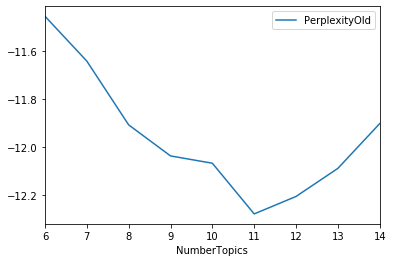

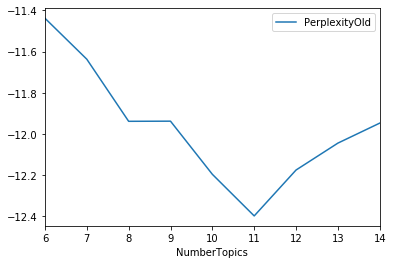

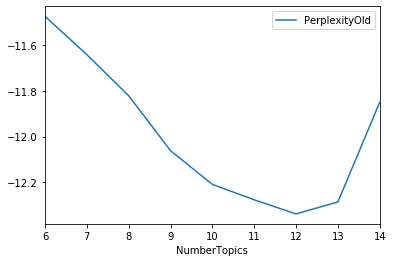

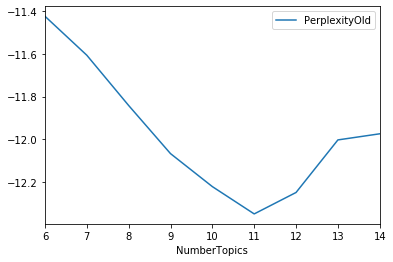

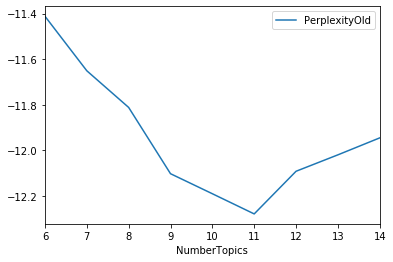

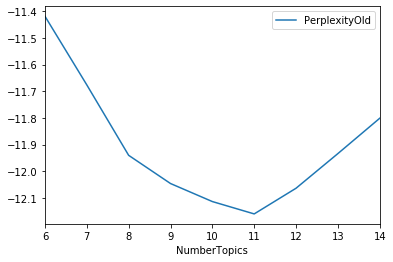

In [11]:
coherence_results = pd.read_pickle('coherence')

for i in np.arange(.5,1.05,.1):
    x = coherence_results[coherence_results['Decay']==i]
    x = x.query('NumberTopics>5')
    x = x.query('NumberTopics<=14')
    x.plot(x='NumberTopics',y='PerplexityOld',kind='line')

We see strong evidence that a model trained with 11 topics leads to minimum perplexity, at least locally. The following two diagrams show perplexity and coherence for varying decay values, where all models were trained with a fixed number of 11 topics.

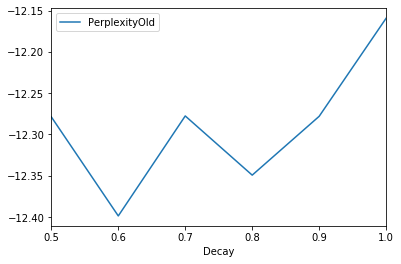

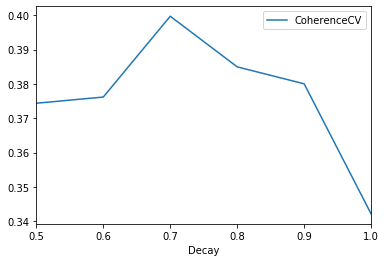

In [12]:
y = coherence_results[coherence_results['NumberTopics']==11]
y.plot(x='Decay',y='PerplexityOld',kind='line')
y.plot(x='Decay',y='CoherenceCV',kind='line')

The minimum perplexity is achieved for a decay value of 0.6 and the maximum coherence values is achieved for a decay of 0.7, so the optimal decay value should be somewhere in between.
In the following we set decay value and number of topics to 0.7 and 11, respectively. Let us have a look at the topics of the model that was trained with these parameter values.

In [73]:
num_topics = 11

lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus = corpus,
                           num_topics = num_topics,
                           id2word = dictionary,
                           chunksize = 100,
                           workers = 7,
                           passes = 50,
                           eval_every = 1,
                           per_word_topics = True,
                           decay = .7
                            )

lda_train.print_topics(11,num_words=15)

[(0,
  '0.023*"great" + 0.014*"people" + 0.013*"north" + 0.012*"korea" + 0.011*"kim" + 0.009*"thank" + 0.008*"jong" + 0.008*"un" + 0.007*"meeting" + 0.007*"vietnam" + 0.006*"forward" + 0.005*"american" + 0.005*"tonight" + 0.005*"last" + 0.005*"hard"'),
 (1,
  '0.017*"dbongino" + 0.016*"whitehouse" + 0.011*"thank" + 0.008*"state" + 0.007*"welcome" + 0.007*"criminal" + 0.007*"united" + 0.006*"great" + 0.006*"trump" + 0.006*"vietnam" + 0.006*"firefighter" + 0.005*"higher" + 0.005*"support" + 0.005*"american" + 0.004*"gdp"'),
 (2,
  '0.016*"hillary" + 0.016*"vote" + 0.011*"crooked" + 0.011*"clinton" + 0.010*"trump" + 0.009*"democrat" + 0.005*"abuse" + 0.005*"collusion" + 0.005*"people" + 0.005*"donaldjtrumpjr" + 0.005*"bill" + 0.005*"great" + 0.005*"court" + 0.005*"page" + 0.004*"dnc"'),
 (3,
  '0.020*"mueller" + 0.018*"collusion" + 0.017*"democrat" + 0.014*"report" + 0.013*"witch" + 0.011*"hunt" + 0.008*"russia" + 0.007*"obstruction" + 0.007*"presidential" + 0.006*"great" + 0.006*"money" 

The resulting topics seem to be more clearly seperated in comparison to our initial model and topics emerge that were hidden previously. For example, the last topic consists of 'united', 'state', 'american' in connection with positive attributes like 'great', 'best' etc. and therefore indicates that it is about talking about the US in a positive manner. 

## Classification with LDA

Now let us assume that we gained more data (e.g. via our tweet scraping procedure) that was transformed into a dataframe called new_data, as before. We then transform the dataframe into a corpus, called new_corpus and query the topic probabilities (w.r.t to the model trained with the old data) of these documents. Note that this works even though the model has not seen the data of new_corpus!
The following shows the topic probabilities assigned to the first document of the new corpus.

In [16]:
new_corpus = get_corpus(new_data)
lda_train.get_document_topics(new_corpus, minimum_probability=0)[0]

[(0, 0.2057447),
 (1, 0.011383173),
 (2, 0.011382565),
 (3, 0.011383603),
 (4, 0.011384137),
 (5, 0.13927898),
 (6, 0.011384096),
 (7, 0.15785445),
 (8, 0.16713133),
 (9, 0.26168954),
 (10, 0.011383396)]

We now use these probabilities to assign the document to the topic with the largest probability value. After this, we use the new data to update our model with the following code.

In [ ]:
lda_train.update(new_corpus)

This updated model can now be used to classify future documents. However, as the number of topics and the topics itself might change rapidly in politics, one should store all the data and train a new model from scratch from time to time (and validate the model as described above), in order to guarantee high performance on the long run.

Text(0.5, 1.0, 'Top 15 Words')

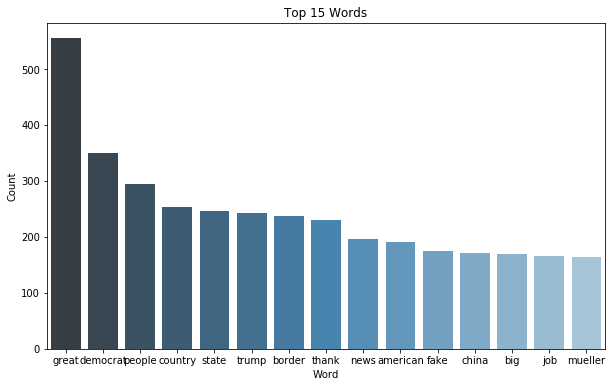

In [13]:
#function that counts number of occurences of a given word in all tweets
def word_count(word):
    j = 0
    for i in words:
        if word == i:
            j += 1
    return j

counted_words = pd.DataFrame({"Word": [w for w in set(words)], "Count": [word_count(w) for w in set(words)]})
counted_words = counted_words.sort_values('Count',ascending=False,axis=0)
counted_words = counted_words.drop(0)

#plot top 15 words
top_15 = counted_words[:15]
plt.figure(figsize=(10,6))
sns.barplot("Word", "Count", data=top_15, palette="Blues_d").set_title("Top 15 Words")

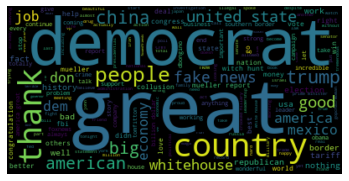

In [15]:
#generate wordcloud
wc = WordCloud()
img = wc.generate_from_text(' '.join(words))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [1]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from textblob import TextBlob, Word
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from string import punctuation

consumer_key = 'Itjy8T6POSReSUrGvDa0MDAC8'
consumer_secret = 'byNZ0LuABijkYq3jOodXCeXnfjRltisWlVt0AmpwodFaBYd2XB'

access_token = '1165867915092119552-cuNoAgjmBvJTy28PnfeOUFgbEzsNR4'
access_token_secret = 'dRuVPVZG39GnnR3IPvmlfk5zXrfavVNBnddrkLy5D9k36'

auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth)

In [78]:
#ACHTUNG!!!!
#mining recent trump tweets
all_tweets = []
coll_tweets = api.user_timeline('realDonaldTrump',count=200,tweet_mode='extended')
all_tweets.extend(coll_tweets)

In [6]:
coll_tweets = [1]
while(len(coll_tweets)>0):
    oldest = all_tweets[-1].id -1
    coll_tweets = api.user_timeline('realDonaldTrump',count=200,max_id=oldest,tweet_mode='extended')
    all_tweets.extend(coll_tweets)

In [2]:
#function to transform collected tweets into pandas dataframe
def tweets_to_df(all_tweets):
    data = pd.DataFrame({"Text": [tweet.full_text for tweet in all_tweets],"Year": [tweet.created_at.year for tweet in all_tweets], "Month": [tweet.created_at.month for tweet in all_tweets], "Day": [tweet.created_at.day for tweet in all_tweets],"Hour": [tweet.created_at.hour for tweet in all_tweets]})
    return data

In [3]:
#function to remove undesirable punctuation from a word
set(punctuation)

def replace_char(w):
    for c in set(punctuation):
        w = w.replace(c,'')
    return w

#list of uninformative words found in words of all collected tweets
uninformatives = ['rt','amp','realdonaldtrump','u','new','would','get','want','never','one','back','even','done','like','make','must','know','ever','thing','going','see','first','two','way','said','also','made','you','look','show','say','left','got','number','getting','really','could','and','come','keep','long','think','year','it','much','many','medium','far','the','day','today','time','president']

#function which cleans a single document and splits it into the single words
def clean_tweets(tweet):
    stop = stopwords.words('english')
    #lowercase all words
    ess_words = [w.lower() for w in tweet.split()]
    #remove stopwords
    ess_words = [w for w in ess_words if not w in stop]
    #remove redundant characters
    ess_words = [replace_char(w) for w in ess_words][:-1]
    #word lemmatization
    ess_words = [Word(w).lemmatize() for w in ess_words]
    #remove uninformative words
    ess_words = [w for w in ess_words if not w in uninformatives]
    return ess_words

def clean_tweets_str(tweet):
    stop = stopwords.words('english')
    #lowercase all words
    ess_words = [w.lower() for w in tweet.split()]
    #remove stopwords
    ess_words = [w for w in ess_words if not w in stop]
    #remove redundant characters
    ess_words = [replace_char(w) for w in ess_words][:-1]
    #word lemmatization
    ess_words = [Word(w).lemmatize() for w in ess_words]
    #remove uninformative words
    ess_words = [w for w in ess_words if not w in uninformatives]
    string = ''
    for w in ess_words:
        string = string  + w + ' '
    return string[:-1]

In [4]:
data = pd.read_pickle('trump')

In [6]:
#function that extracts cleaned words from whole corpus
def extract_words(df):
    all_words = []
    for tweet in df.Text:
        all_words += clean_tweets(tweet)
    return all_words

#function that extracts cleaned tweets in a list   
def extract_tweets(df):
    all_tweets = []
    for tweet in df.Text:
        all_tweets += [clean_tweets_str(tweet)]
    return all_tweets

words = extract_words(data)
tweets = extract_tweets(data)

In [7]:
new_data = pd.read_pickle('new_trump')
new_tweets = extract_tweets(new_data)

In [8]:
import gensim

def get_dict(df):
    corpus = [tweet.split() for tweet in extract_tweets(df)]
    id2word = gensim.corpora.Dictionary(corpus)
    return id2word

dictionary = get_dict(data)

def get_corpus(df):
    corpus = [dictionary.doc2bow(tweet.split()) for tweet in extract_tweets(df)]
    return corpus

corpus = get_corpus(data)
new_corpus = get_corpus(new_data)

In [37]:
split_tweets = [tweet.split() for tweet in tweets]

c_v = []
c_uci = []
u_mass = []
decays = []
topic_nums = []
new_perplexity = []
perplexity = []

for decay in np.arange(.5,1.05,.1):
    for num_topics in range(3,40):
        lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus = corpus,
                           num_topics = num_topics,
                           id2word = dictionary,
                           chunksize = 100,
                           workers = 7,
                           passes = 50,
                           eval_every = 1,
                           per_word_topics = True,
                           decay = decay
                            )
        
        coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_train, texts=split_tweets, dictionary=dictionary, coherence='c_v')
        c_v.append(coherence_model_lda.get_coherence())
        coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_train, texts=split_tweets, dictionary=dictionary, coherence='c_uci')
        c_uci.append(coherence_model_lda.get_coherence())
        coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_train, texts=split_tweets, dictionary=dictionary, coherence='u_mass')
        u_mass.append(coherence_model_lda.get_coherence())
        decays.append(decay)
        topic_nums.append(num_topics)
        new_perplexity.append(lda_train.log_perplexity(new_corpus))
        perplexity.append(lda_train.log_perplexity(get_corpus(data[:500])))
        
zippedList = list(zip(decays,topic_nums,c_v,c_uci,u_mass,new_perplexity,perplexity))
coherence_results = pd.DataFrame(zippedList,columns=['Decay','NumberTopics','CoherenceCV','CoherenceCUCI','CoherenceUMASS','PerplexityNew','PerplexityOld'])
pd.to_pickle(coherence_results,'coherence')